# SJSU MSDS 255 DL, Spring 2024
Homework 03: Custom CNNs

Git: https://github.com/jrgosalvez/data255_DL

In [1]:
# Setup experiment and import CIFAR data from Pytorch
# https://pytorch.org/vision/stable/datasets.html

import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
import os

import matplotlib.pyplot as plt

# Without a pretrained model

## 1. Create custom dataset of 3 categories from CIFAR10 with at least 100 images each

MSDA 255, Fall demo_03-classification examples referenced

In [2]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

In [3]:
# Define transform to preprocess the data. NOTE: can define transformations for train and test (validation) sets. 
# Will keep simple for this model
transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
# Load CIFAR10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
num_classes = len(class_names)
print(num_classes)

10


10 classes as part of CIFAR10 dataset

In [9]:
# select classes you want to include in your subset
# https://www.cs.toronto.edu/~kriz/cifar.html 
# 10 classes total, picked three; 0: airplane, 2: bird, 6: frog
classes = torch.tensor([0, 2, 6])         

# get indices that correspond to one of the selected classes
indices = (torch.tensor(trainset.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
test_indices = (torch.tensor(testset.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]

In [10]:
# subset the dataset and reduce to 1/4th the size and randamize
data = Subset(trainset, indices)

In [11]:
# 1/7th the datapoints of each of the three classes from the trainset
total = len(data)
train_data = torch.utils.data.random_split(data, [total//7, total-total//7])[0]
t_data = torch.utils.data.random_split(data, [total//7, total-total//7])[0]
print(len(train_data))
print(len(t_data))

2142
2142


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


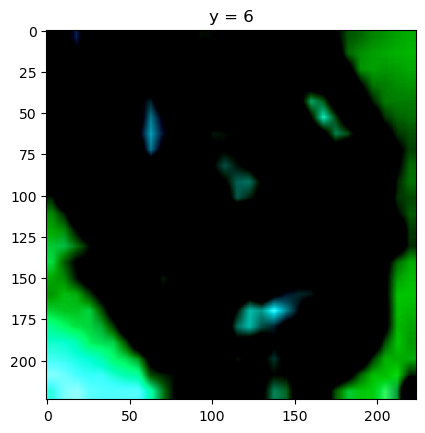

In [12]:
show_data(train_data[8])

## 2. Split custom data 80% training and 20% validation set for training and testing

In [13]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_data))
val_size   = len(train_data) - train_size
train_data, valset = torch.utils.data.random_split(train_data, [train_size, val_size])

In [14]:
# Define data loaders
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_dataloader   = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
test_dataloader  = DataLoader(t_data, batch_size=64, shuffle=False, num_workers=2)

# Check the size of each dataset
print("Training set size:", len(train_data))
print("Validation set size:", len(valset))
print("Test set size:", len(t_data))
print(f"Train + Val {len(train_data) + len(valset)} | Test Set {len(t_data)}")

Training set size: 1713
Validation set size: 429
Test set size: 2142
Train + Val 2142 | Test Set 2142


## 3. Preprocess data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

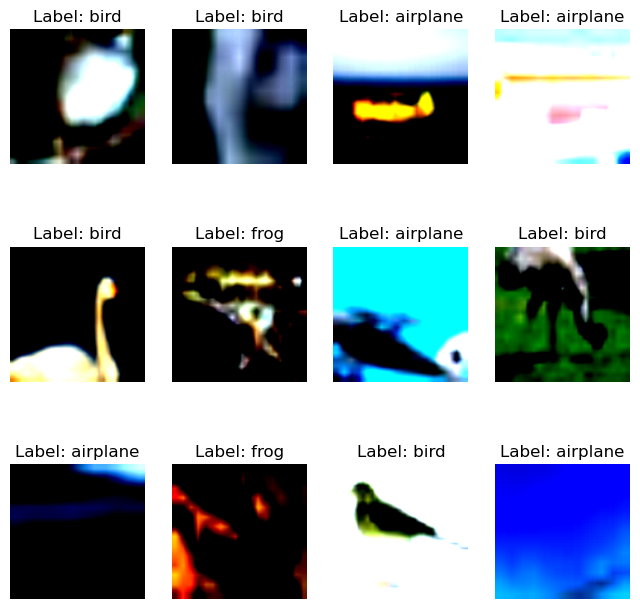

In [15]:
# train_dataloader is PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 12 images
plt.figure(figsize=(8, 8))
for i in range(12):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

In [16]:
print(f'Length of train dataloader: {len(train_dataloader.dataset)}')
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Length of train dataloader: 1713
torch.Size([64, 3, 224, 224])
torch.Size([64])


torch.size (batch, channel, image size X, image size Y), where the image batch is tensor of shape ([64, 3, 224, 224]) with a batch of 64 images. The shape of these images is 244x244x3 based on center out transformation. Images are blury b/c they are stretched, native images are 32x32. 3 indicates the channel (e.g. RBG, not gray or other).

In [17]:
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)
print(images.shape)
print(labels.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64])


## 4. Create CNN to learn training set

In [18]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

# Instantiate the model
# num_classes = 10                # 10 categories in CIFAR dataset
model = CustomModel(num_classes)

# Print the model architecture
print(model)

CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1605632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),                 
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 224, 224

# Define the number of classes
# num_classes = 10

# Instantiate the model woTransfer
model = CNNModel(num_classes, img_height, img_width)

In [20]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
criterion = nn.CrossEntropyLoss()

In [21]:
# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc  = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [22]:
%%time
# Train the model
num_epochs = 3  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 1.3408, Accuracy: 0.3497
Epoch 2/3, Loss: 1.0268, Accuracy: 0.4781
Epoch 3/3, Loss: 0.9585, Accuracy: 0.5406
CPU times: user 5min 24s, sys: 1min 29s, total: 6min 53s
Wall time: 4min 15s


### Retrain with data augmentation

In [23]:
%%time
# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc  = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
    return epoch_loss, epoch_acc    

# Train the model
num_epochs = 3         # Choose the number of epochs
m1_epoch_loss, m1_epoch_acc = train_model(model, train_dataloader, criterion, optimizer, num_epochs)
print(f'Model Final: loss {m1_epoch_loss:.4f} | accuracy {m1_epoch_acc:.4f}')

Epoch 1/3, Loss: 0.8994, Accuracy: 0.5867
Epoch 2/3, Loss: 0.8749, Accuracy: 0.6013
Epoch 3/3, Loss: 0.8522, Accuracy: 0.6025
Model Final: loss 0.8522 | accuracy 0.6025
CPU times: user 5min 44s, sys: 1min 59s, total: 7min 43s
Wall time: 4min 39s


## 5. Make predictions on test dataset and compare accuracy to expected categories

In [24]:
from PIL import Image
import requests
from io import BytesIO
from torch import argmax

In [25]:
img_height, img_width = 224, 224

# Define the location of the image
# https://cdn.britannica.com/q:60/69/155469-131-14083F59/airplane-flight.jpg
# https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwallpaperping.com%2Fwp-content%2Fuploads%2F2018%2F12%2FBluebirdTotemMeaning.jpg&f=1&nofb=1&ipt=e42988b50087ff8103148dbf1986ebc6ab978591f8c24439a42ed21fce1a0b16&ipo=images
# another frog: https://www.welcomewildlife.com/wp-content/uploads/2015/01/Frog-compare.jpg
frog_url = "https://zoo.bca.ac.uk/wp-content/uploads/sites/2/2020/02/BCA-Small-Size-101.jpg"

# Download the image and convert it to a PyTorch tensor
response = requests.get(frog_url)
img = Image.open(BytesIO(response.content)).convert('RGB')
img = img.resize((img_width, img_height))  # Resize the image to match the model's input size
img_tensor = transforms.ToTensor()(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Move the tensor to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

In [26]:
# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(img_tensor)
    probabilities = torch.softmax(outputs, dim=1)

# Convert tensor to numpy array
predicted_class = class_names[argmax(probabilities)]

# Print the predicted class and confidence
predicted_class = class_names[torch.argmax(probabilities)]
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class} with a {confidence*100:.2f}% confidence.")

This image most likely belongs to frog with a 57.76% confidence.


#### Test prediction on single image

In [27]:
# Load and preprocess the unseen image
image_path = 'frog.jpg'               # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [28]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(outputs, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")

This image most likely belongs to frog with a 57.76% confidence.


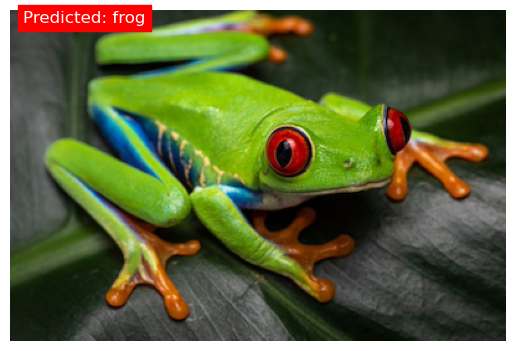

In [29]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

### With input batch created, create function to apply to multiple images

In [30]:
def check(image, input_batch):
    # Load and preprocess the unseen image
    image_path = image               # Replace with the path to your image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    
    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    _, predicted_class = output.max(1)

    # Map the predicted class to the class name
    predicted_class_name = class_names[predicted_class.item()]
    probabilities = torch.softmax(outputs, dim=1)
    confidence = torch.max(probabilities).item()
    print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")
    print()
    
    # Display the image with the predicted class name
    image = np.array(image)
    plt.imshow(image)
    plt.axis('off')
    plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
    plt.show()
    
    return input_batch

This image most likely belongs to frog with a 57.76% confidence.



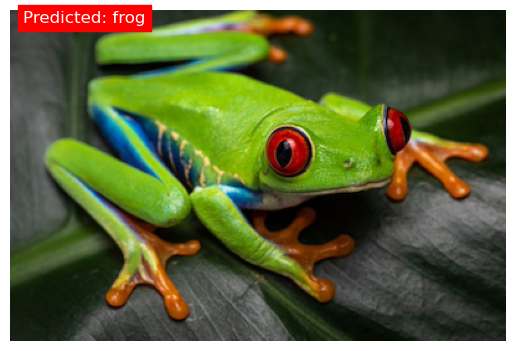

This image most likely belongs to airplane with a 57.76% confidence.



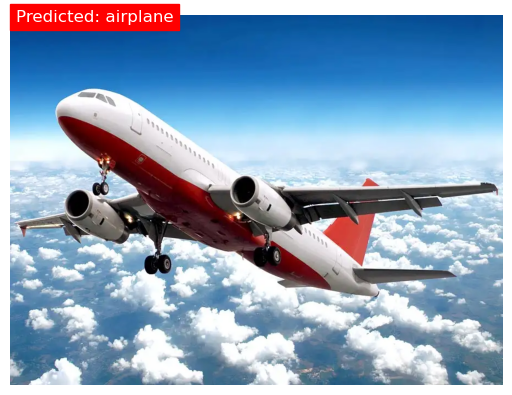

This image most likely belongs to bird with a 57.76% confidence.



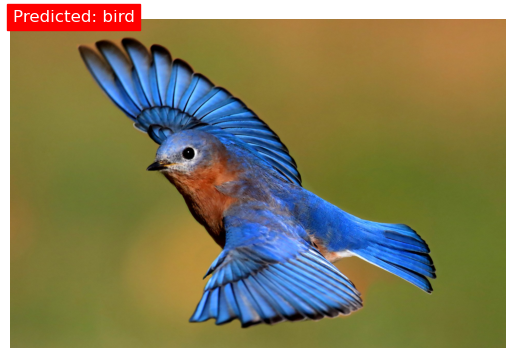

This image most likely belongs to airplane with a 57.76% confidence.



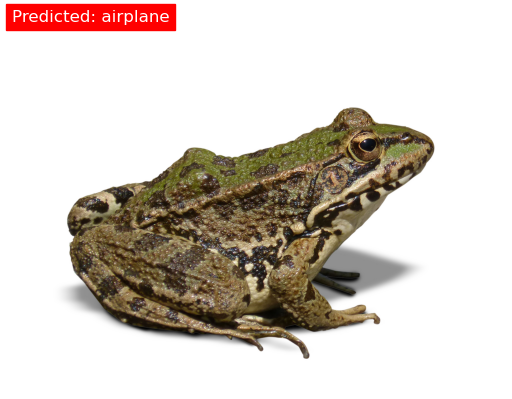

In [31]:
new_images = ['frog.jpg', 'airplane.jpg', 'bird.jpg', 'frog2.jpg']

for i in new_images:
    check(i, input_batch)

- Event with augmenting data to increase accuracy and confidence. 
- Images must be same size (e.g. uniform or processed to be uniform. For example, transparent images can cause challenges)

## Now with a pretrained model...

## 6. Use GoogleNet (InceptionNet) and add a LinearLayer

#### Experiment by creating a local copy of data

In [32]:
# Define the data directory  # train_dataloader
data_dir = './data'

# Create a directory to save the images if it doesn't exist
save_dir = os.path.join(data_dir, 'train')
os.makedirs(save_dir, exist_ok=True)

for i, (image, label) in enumerate(train_data):
    # Remove the batch dimension if it exists
    image = image.squeeze(0) if len(image.size()) == 4 else image
    
    # Convert the tensor image to PIL image
    pil_image = transforms.ToPILImage()(image)
    
    # Define the subdirectory based on the label
    label_dir = os.path.join(save_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)
    
    # Define the filename for saving
    filename = os.path.join(label_dir, f'image_{i}.jpg')
    
    # Save the PIL image as a JPEG file
    pil_image.save(filename)

In [33]:
# Create a val directory with sub folders for 3 classes to save the images if it doesn't exist
save_dir = os.path.join(data_dir, 'val')
os.makedirs(save_dir, exist_ok=True)

for i, (image, label) in enumerate(valset):
    # Remove the batch dimension if it exists
    image = image.squeeze(0) if len(image.size()) == 4 else image
    
    #for i in range(3):
    #    print(label)
    
    # Convert the tensor image to PIL image
    pil_image = transforms.ToPILImage()(image)
    
    # Define the subdirectory based on the label
    label_dir = os.path.join(save_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)
    
    # Define the filename for saving
    filename = os.path.join(label_dir, f'image_{i}.jpg')
    
    # Save the PIL image as a JPEG file
    pil_image.save(filename)

In [34]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),    # resize for inception v3 <<<< required!
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [35]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 4968
     Root location: ./data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 1232
     Root location: ./data/val
     StandardTransform
 Transform: Compose(
                Resize(size=299, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(299, 299))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [36]:
dataloaders   = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 4968, 'val': 1232}


['0', '2', '6']

In [37]:
# Load the pre-trained ResNet-18 model - works b/c kernel and input sizes fit 3x3
# model = models.resnet18(pretrained=True)

# Load the pre-trained inception_v3 model - does not work b/c kernel is 5x5 versus 3x3 inputs, need to set final 
model = models.inception_v3(pretrained=True)   
model.aux_logits = False                       # inception v3 
# print(model)

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/python311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [39]:
%%time
# Training loop
new_acc    = 0.0
new_acc    = 0.0
num_epochs = 3
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)            # inception v3 requires images of size 299x299, which is done in the encoder/decoder during transform or for aux_logits = False
            labels = labels.to(device)
            #print(inputs.size())

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc  = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        new_acc  = epoch_acc
        new_loss = epoch_loss
        
print(f'Transfer Learning Model Final: loss {new_loss:.4f} | accuracy {new_acc:.4f}')
print("Training complete!")

train Loss: 1.1920 Acc: 0.4605
val Loss: 0.9323 Acc: 0.5771
train Loss: 1.1299 Acc: 0.5052
val Loss: 0.8110 Acc: 0.6356
train Loss: 1.1087 Acc: 0.5139
val Loss: 0.9193 Acc: 0.6144
Transfer Learning Model Final: loss 0.9193 | accuracy 0.6144
Training complete!
CPU times: user 2h 7min 39s, sys: 9min 45s, total: 2h 17min 24s
Wall time: 1h 12min 57s


In [40]:
# Save the model
torch.save(model.state_dict(), '3_class_CIFAR_classification_model.pth')

In [41]:
# Load the saved modelmodel = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('3_class_CIFAR_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
#new_model = models.resnet18(pretrained=True)
new_model = models.inception_v3(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data   = model.fc.bias.data[0:2]

In [55]:
def check_new(image, input_batch):
    # Load and preprocess the unseen image
    image_path = image  # Replace with the path to your image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    
    # Perform inference
    with torch.no_grad():
        output = new_model(input_batch)

    # Get the predicted class
    _, predicted_class = output.max(1)

    # Map the predicted class to the class name
    class_names = ['0', '2', '6']      # Make sure these class names match your training data
    predicted_class_name = class_names[predicted_class.item()]
    probabilities = torch.softmax(outputs, dim=1)
    confidence = torch.max(probabilities).item()
    print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")
    print()

    for i in predicted_class_name:
        if i == '0':
            predicted_class_name_text = 'airplane'
        if i == '2':
            predicted_class_name_text = 'bird'
        if i == '6':
            predicted_class_name_text = 'frog'

    print(f'The predicted class is: {predicted_class_name}')
    print(f'The predicted class is: {predicted_class_name_text}')

    # Display the image with the predicted class name
    image = np.array(image)
    plt.imshow(image)
    plt.axis('off')
    plt.text(10, 10, f'Predicted: {predicted_class_name}, which is {predicted_class_name_text}', fontsize=12, color='white', backgroundcolor='red')
    plt.show()
    
    return input_batch

In [56]:
new_images = ['frog.jpg', 'airplane.jpg', 'bird.jpg', 'frog2.jpg']

for i in new_images:
    check_new(i, input_batch)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])

## 7. Train the GoogleNet (InceptionNet) model and compare the accuracy with the first model

In [44]:
print(f'By Hand Model Final:           loss {m1_epoch_loss:.4f} | accuracy {m1_epoch_acc:.4f}')
print(f'Transfer Learning Model Final: loss {new_loss:.4f} | accuracy {new_acc:.4f}')

By Hand Model Final:           loss 0.8522 | accuracy 0.6025
Transfer Learning Model Final: loss 0.9193 | accuracy 0.6144


Transfer learning outperformed the hand made model and sped up the process by not having to train the depth of a fully connected NN. 

- Transfer learning outperformed the hand made model and sped up the process by not having to train the depth of a fully connected NN. 
- ResNet and GoogleNet were significantly faster than inception_v3
- Inception v3 require preprocessing to ensure kernels and inputs fit, for examples images must be 299 x 299
- Parameter tuning and transforming are key
- Transfer learning on this small dataset is computationaly expensive

In [49]:
input_batch

tensor([[[[-1.2274, -1.2445, -1.2788,  ..., -1.8439, -1.8439, -1.8439],
          [-1.1247, -1.0733, -1.0562,  ..., -1.8439, -1.8439, -1.8439],
          [-0.7822, -0.6965, -0.6452,  ..., -1.8268, -1.8268, -1.8268],
          ...,
          [-0.7650, -0.8678, -0.7822,  ..., -1.6384, -1.6042, -1.4843],
          [-0.7993, -0.9192, -0.8849,  ..., -1.6555, -1.5699, -1.5357],
          [-0.8849, -1.0562, -0.9877,  ..., -1.5528, -1.5185, -1.5014]],

         [[-0.9678, -0.9503, -0.9853,  ..., -1.5630, -1.5630, -1.5630],
          [-0.7927, -0.7052, -0.6877,  ..., -1.5630, -1.5630, -1.5630],
          [-0.3375, -0.2325, -0.1450,  ..., -1.5455, -1.5455, -1.5455],
          ...,
          [-0.6001, -0.7227, -0.6352,  ..., -1.3704, -1.3354, -1.2304],
          [-0.6527, -0.7752, -0.7402,  ..., -1.3880, -1.3004, -1.2654],
          [-0.7402, -0.9153, -0.8452,  ..., -1.2829, -1.2654, -1.2654]],

         [[-0.9156, -0.9156, -0.9504,  ..., -1.6127, -1.6127, -1.6127],
          [-0.8633, -0.8458, -